In [ ]:
!conda install -c conda-forge -y librosa

In [1]:
import numpy as np
import pandas as pd
import time
import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from boris_util import *

In [2]:
# https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0


y, sr = librosa.load('453_923_bundle_archive/set_a/murmur__201108222255.wav')

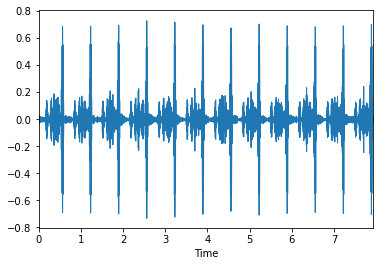

In [3]:
librosa.display.waveplot(y, sr=sr);

In [ ]:
n_fft = 2048
D = np.abs(librosa.stft(y[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
print(D.shape)
plt.plot(D);

(1025, 1006)


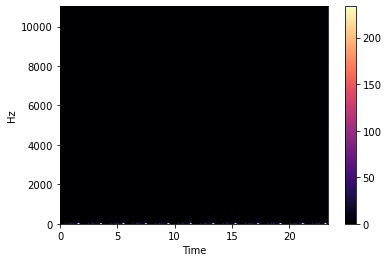

In [21]:
hop_length = y.shape[0]//1000
D = np.abs(librosa.stft(y, n_fft=n_fft,  hop_length=hop_length))
print(D.shape)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

In [22]:
y.shape[0]/hop_length

1005.6264367816092

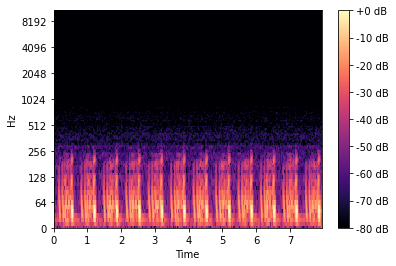

In [14]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

(128, 1006)


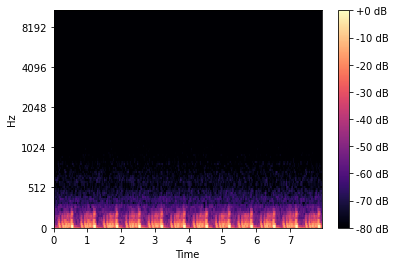

In [17]:
n_mels=128
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
print(S_DB.shape)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [ ]:
S_DB.shape

In [ ]:
S

In [1]:
import numpy as np
import pandas as pd
import time
import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from boris_util import *

# Exploring the Dataset

First thing's first, let's load the dataset. I created a new function that loads up the dataset for me and converts it into a pandas dataframe for easy access. For more information on this, please see the `Data Cleaning` notebook

In [2]:
dataset = read_and_combine_data('453_923_bundle_archive', read_noisy_data=False)
print(dataset.shape)
dataset.head()

(436, 3)d 99.77%


,signal,sampling_rate,label
0,"[2.2960085e-05, -0.00012982322, -0.00018070513...",22050,artifact
1,"[-1.0927635e-05, 1.0574424e-06, 2.108567e-06, ...",22050,artifact
2,"[3.728857e-05, -0.0001664555, -7.4023155e-05, ...",22050,artifact
3,"[-0.0027429417, -0.0066496185, -0.0049779303, ...",22050,artifact
4,"[0.000106223946, 0.0015002153, 0.0097254915, 0...",22050,artifact


Let's take a look at the class distribution to see if there is any concern of class imbalance

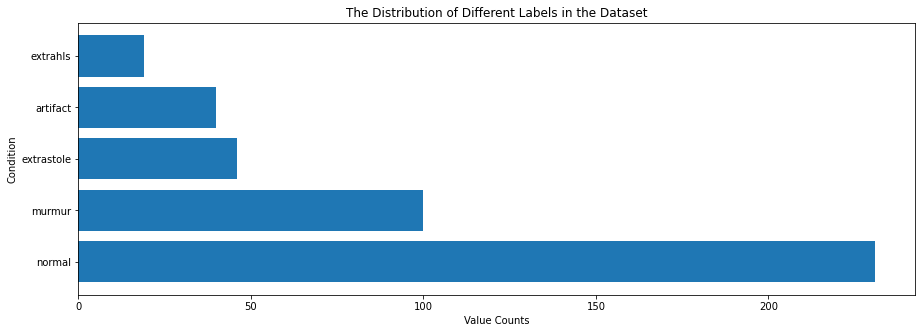

In [3]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Dataset")
plt.show()

There is certainly an issue of class imbalance here. A naive classifier could guess pretty well by simply guessing "Normal" on all the examples

## Combine all Abnormalities

Let's try a simple example first, we will combine all abnormalities into a single label "abnormal". We won't count artifacts in that category

In [4]:
def relabel(label):
    if (label == "normal"):
        return "normal"
    elif (label == "artifact"):
        return "artifact"
    else:
        return "abnormal"
dataset['label'] = dataset['label'].apply(relabel)

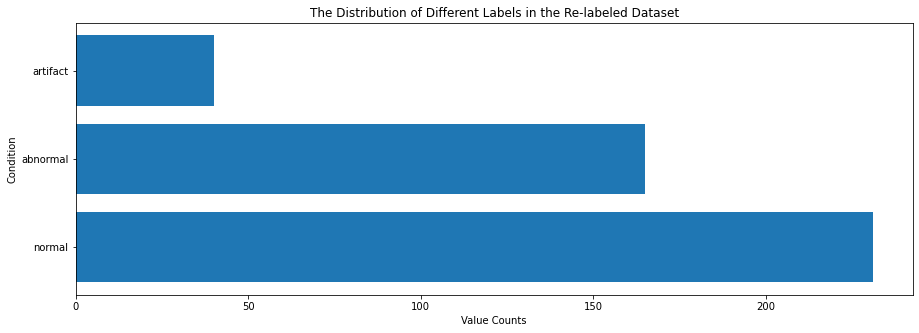

In [5]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Re-labeled Dataset")
plt.show()

Let's split our data now into a simple train/test stratified split

In [6]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset['label'], random_state=1)
print(train_dataset.shape)
print(test_dataset.shape)

(348, 3)
(88, 3)


In [7]:
train_dataset.head()

,signal,sampling_rate,label
256,"[0.10968155, 0.1198264, 0.124032594, 0.1228437...",22050,normal
63,"[0.0011411144, 0.0019435775, -4.689005e-05, -0...",22050,abnormal
152,"[0.008070375, 0.009497889, 0.010761451, 0.0118...",22050,abnormal
1,"[-1.0927635e-05, 1.0574424e-06, 2.108567e-06, ...",22050,artifact
229,"[0.007627283, 0.008212427, 0.008293857, 0.0079...",22050,abnormal


Let's define a function that will find the longest signal in our dataframe

Now let's define a class which will convert the signals into Mel spectrograms

In [8]:
class MelEncoder:
    
    def __init__(self, n_fft=2048, hop_length=512, n_mels=128, sampling_rate=22050.0, verbose=0):
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sampling_rate = sampling_rate
    
    def fit(self, X, y=None):
        self.longest_signal = self._longest_signal(X)
        
    
    def transform(self, X):
        X_list = []
        
        for signal in X:
            mel_spectrogram = self._signal_to_mel_spectrogram(signal)
            X_list.append(mel_spectrogram)
            
        return np.array(X_list)
        
        
        
        
    # https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
    def _longest_signal(self, signals):
        max_length = 0
        for signal in signals:
            if (len(signal) > max_length):
                max_length = len(signal)

        return max_length
    
    
    def _signal_to_mel_spectrogram(self, signal):
        new_signal = np.zeros((self.longest_signal, ))
        new_signal[-signal.shape[0]:] = signal[:]
        S = librosa.feature.melspectrogram(new_signal, 
                                           sr=self.sampling_rate, 
                                           n_fft=self.n_fft, 
                                           hop_length=self.hop_length, 
                                           n_mels=self.n_mels)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return S_DB

In [9]:
my_encoder = MelEncoder()

In [10]:
my_encoder.fit(train_dataset['signal'])

In [11]:
X_train_mel = my_encoder.transform(train_dataset['signal'])

In [12]:
X_train_mel.shape

(348, 128, 1041)

In [13]:
X_test_mel = my_encoder.transform(test_dataset['signal'])

In [14]:
X_test_mel.shape

(88, 128, 1041)

## Basic Model - Logistic Regression

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

condition_label_encoder = LabelEncoder()

X_train = X_train_mel.reshape(X_train_mel.shape[0], -1)
X_test = X_test_mel.reshape(X_test_mel.shape[0], -1)


y_train = condition_label_encoder.fit_transform(train_dataset['label'])
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(348, 133248) (88, 133248)
(348,) (88,)


In [30]:
from sklearn.linear_model import LogisticRegression

fit_start = time.time()
my_logit = LogisticRegression(random_state=1).fit(X_train, y_train)
fit_end = time.time()
print(f"Fitting took {round(fit_end - fit_start,2)} seconds")

train_acc = my_logit.score(X_train, y_train)
test_acc = my_logit.score(X_test, y_test)

Fitting took 14.63 seconds


In [31]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 92.82%
The test accuracy is 67.05%


Extremely suspicious results. There is clearly a very large sign of overfitting here. Let's explore how the logistic regression makes decisions.

Let's plot the coefficients as if they were an audio mask (which is really what they end up becoming).

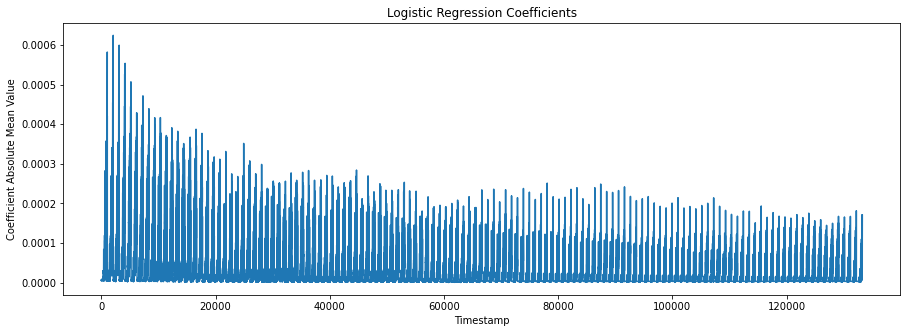

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(np.abs(my_logit.coef_).mean(axis=0))
plt.xlabel("Timestamp")
plt.ylabel("Coefficient Absolute Mean Value")
plt.title("Logistic Regression Coefficients")
plt.show()

Most of the decision is happening at the beginning of the sound

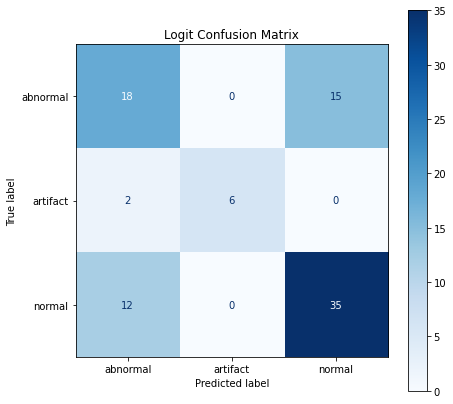

In [33]:
from sklearn.metrics import plot_confusion_matrix

figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

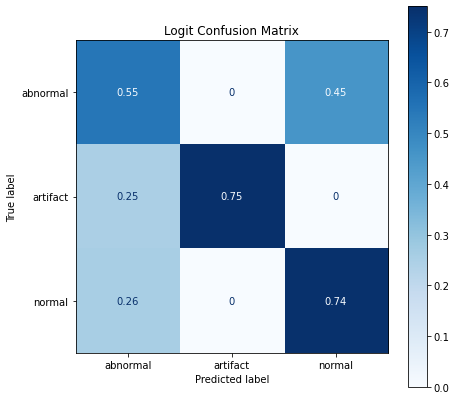

In [34]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [35]:
from sklearn.metrics import classification_report


print(classification_report(y_test, my_logit.predict(X_test)))

              precision    recall  f1-score   support

           0       0.56      0.55      0.55        33
           1       1.00      0.75      0.86         8
           2       0.70      0.74      0.72        47

    accuracy                           0.67        88
   macro avg       0.75      0.68      0.71        88
weighted avg       0.68      0.67      0.67        88



## Basic Model - Decision Tree

As another baseline, I will train a decision tree to see if introducing non-linearity to the learning process produces better results

In [21]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(348, 133248) (88, 133248)
(348,) (88,)


In [22]:
from sklearn.tree import DecisionTreeClassifier

fit_start = time.time()

# Let's set some regularization otherwise we know the tree will overfit
my_tree = DecisionTreeClassifier(min_samples_leaf=2, random_state=1).fit(X_train, y_train)

fit_end = time.time()
print(f"Fitting took {round(fit_end - fit_start,2)} seconds")

train_acc = my_tree.score(X_train, y_train)
test_acc = my_tree.score(X_test, y_test)

Fitting took 6.26 seconds


In [23]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 97.7%
The test accuracy is 68.18%


Much better results! However, let's see how the model performs using the confusion matrix of the test set



In [24]:
from sklearn.metrics import plot_confusion_matrix

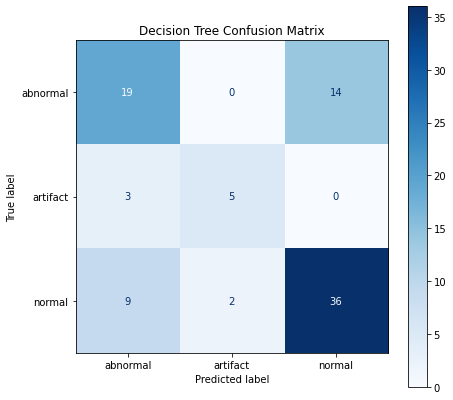

In [25]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_tree, X_test, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

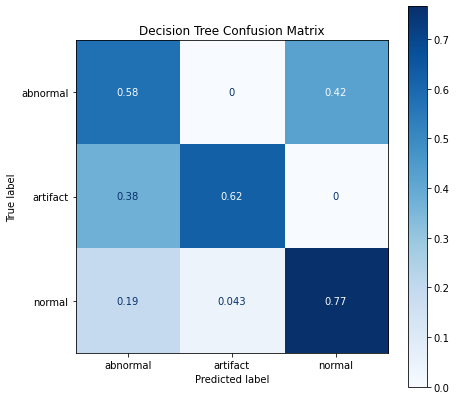

In [26]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_tree, X_test, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

As suspected, quite a bit of the classification seems to classify abnormal conditions and sounds as "normal" due to the sheer volume of that class, but interestingly, ~39% of the normal examples get misclassified as abnormalities.

Let's see which feature the tree considers important:

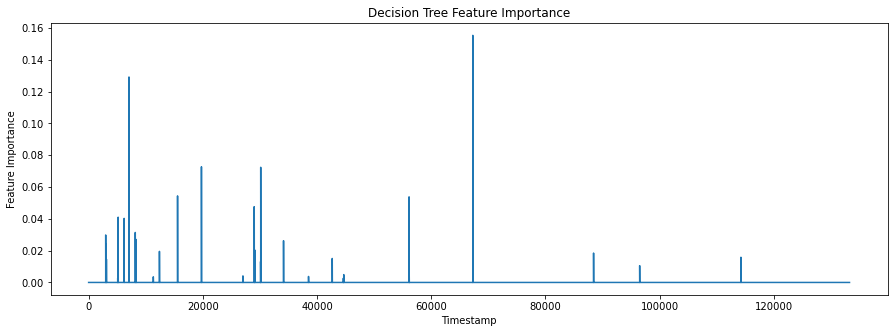

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(my_tree.feature_importances_)
plt.xlabel("Timestamp")
plt.ylabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()

In [29]:
from sklearn.metrics import classification_report


print(classification_report(y_test, my_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.58      0.59        33
           1       0.71      0.62      0.67         8
           2       0.72      0.77      0.74        47

    accuracy                           0.68        88
   macro avg       0.68      0.66      0.67        88
weighted avg       0.68      0.68      0.68        88

